In [116]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import scipy.stats
import seaborn as sns
import os
sns.set()

-> 1 output files will be processed for each experiment.
-> calculating confidence intervals for the difference of the realizations...
-> generating summary of results...
-> per-station statistics
-> generating utilization summaries...


/home/agu/pyenv/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/agu/pyenv/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


-> generating utilization visualizations...
-> generating distribution visualization for the stations with highest utilization


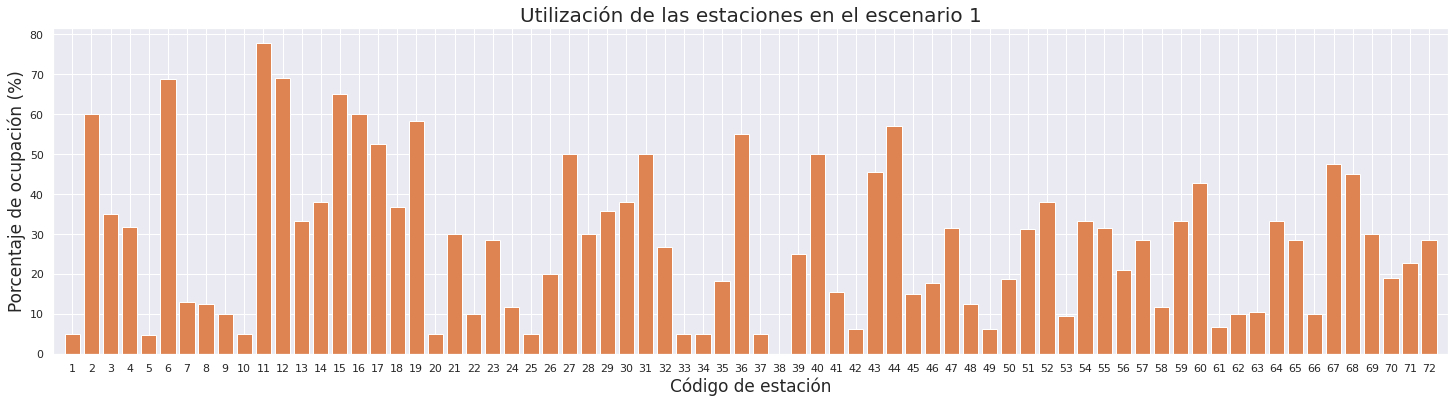

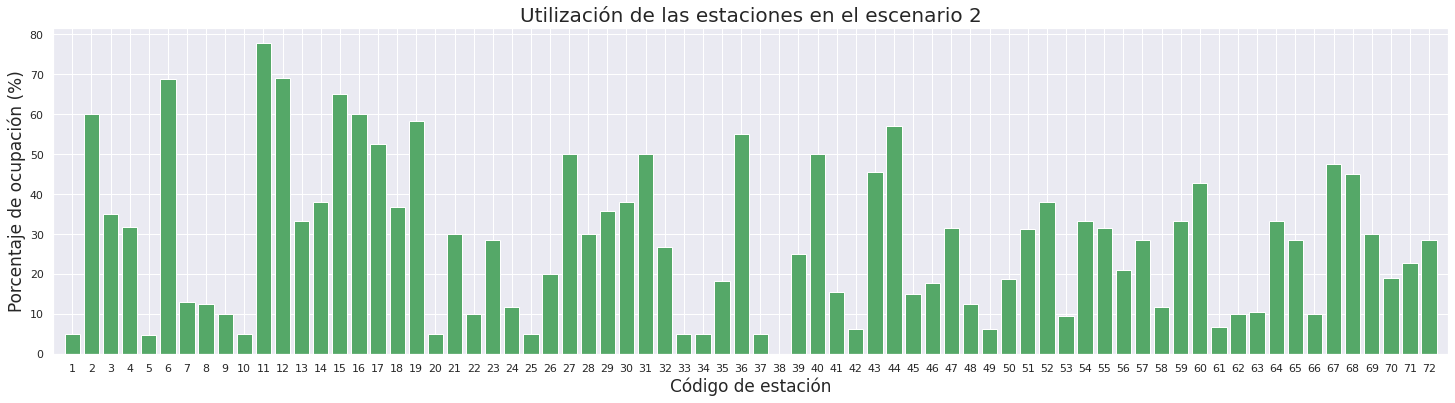

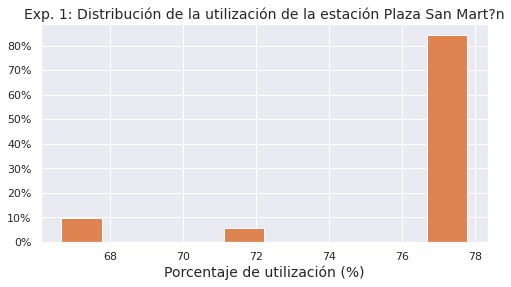

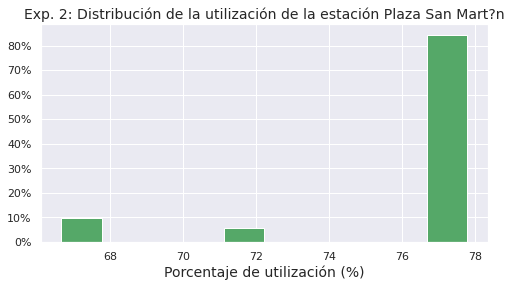

In [127]:
model_path = '../Modelo/MiBiciTuBici'
model_output_path = f'{model_path}/model-output'
processed_output_path = f'{model_path}/processed-model-output/'
experiment_1_path = f'{model_output_path}/experiment-1'
experiment_2_path = f'{model_output_path}/experiment-2'

# --> Sanity checks
if not os.path.exists(model_output_path) or len(os.listdir(model_output_path)) == 0:
    raise Exception('No model output is available. Run the AnyLogic experiment and try again.')
if not os.path.exists(experiment_1_path) or len(os.listdir(experiment_1_path)) == 0:
    raise Exception('No model output is available for experiment 1. Run the AnyLogic experiment and try again.')
if not os.path.exists(experiment_2_path) or len(os.listdir(experiment_2_path)) == 0:
    raise Exception('No model output is available for experiment 2. Run the AnyLogic experiment and try again.')

if not os.path.exists(processed_output_path):
    os.mkdir(processed_output_path)

experiment_1_files = os.listdir(experiment_1_path)
experiment_2_files = os.listdir(experiment_2_path)

if len(experiment_1_files) != len(experiment_2_files):
    raise Exception('The amount of files for experiment 1 do not match with the amount for experiment 2. Aborting.')

for file in experiment_1_files:
    if not file.startswith('output') and not file.endswith('.json'):
        raise Exception(f'File {file} is not recognized. Aborting.')

for file in experiment_2_files:
    if not file.startswith('output') and not file.endswith('.json'):
        raise Exception(f'File {file} is not recognized. Aborting.')

print(f'-> {len(experiment_1_files)} output files will be processed for each experiment.')
# -----------------------

def mean_confidence_interval(data, confidence=0.90):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

n_replications = len(experiment_1_files)

statistics = (
    'totalUsers',
    'co2Avoided',
    'totalKm',
    'totalLostCustomers',
    'delayedUsers',
    'totalLostTime',
)

results_exp_1 = { f'{statistic}': [] for statistic in statistics }
results_exp_2 = { f'{statistic}': [] for statistic in statistics }
results_difference = { f'{statistic}': [] for statistic in statistics }

# results_exp_1
# ├── 'totalUsers': [rep1, rep2, rep3,...,rep100]
# ├── 'co2Avoided':[rep1, rep2, rep3,...,rep100]
# ├── 'totalKm': [rep1, rep2, rep3,...,rep100]
# ├── 'totalLostCustomers': [rep1, rep2, rep3,...,rep100]
# ├── 'delayedUsers': [rep1, rep2, rep3,...,rep100]
# └── 'totalLostTime': [rep1, rep2, rep3,...,rep100]

stations_population_data_exp_1 = []
stations_population_data_exp_2 = []

# stations_populations_data_exp_1
# ├── replication 1
# │   ├── estacion 1
# │   ├── estacion 2
# │   ├── estacion 3
# │   └── ...
# ├── replication 2
# │   ├── estacion 1
# │   ├── estacion 2
# │   ├── estacion 3
# │   └── ...
# ├── replication 3
# │   ├── estacion 1
# │   ├── estacion 2
# │   ├── estacion 3
# │   └── ...
# ├── ...
# └── replication 100

# Load files content in memory
for output_file in experiment_1_files:
    with open(f'{model_output_path}/{output_file}') as f:
        data = json.load(f)

    stations_population_data_exp_1.append(data['estaciones'])

    for statistic in statistics:
        results_exp_1[statistic].append(data[statistic])

for output_file in experiment_2_files:
    with open(f'{model_output_path}/{output_file}') as f:
        data = json.load(f)

    stations_population_data_exp_2.append(data['estaciones'])

    for statistic in statistics:
        results_exp_2[statistic].append(data[statistic])

# -----------------------------

# --> Confidence intervals for the difference
print('-> calculating confidence intervals for the difference of the realizations...')
confidence_intervals = { f'{statistic}': None for statistic in statistics }

for statistic in statistics:
    results_difference[statistic].append(np.array(results_exp_1[statistic]) - np.array(results_exp_2[statistic]))

for statistic, values in results_difference.items():
    mean, lower, upper = mean_confidence_interval(values)
    confidence_intervals[statistic] = (lower, mean, upper)

confidence_intervals = pd.DataFrame(confidence_intervals).transpose()
confidence_intervals.columns = ('Cota inferior', 'Media', 'Cota superior')
confidence_intervals = confidence_intervals.round(decimals=2)
confidence_intervals.to_csv('../Modelo/MiBiciTuBici/processed-model-output/intervals.csv')
# ------------------------------------------

# --> Summary of results for all statistics of interest
print('-> generating summary of results...')
summary_exp_1 = pd.DataFrame(results_exp_1).describe().round(decimals=2)
summary_exp_2 = pd.DataFrame(results_exp_2).describe().round(decimals=2)
summary_exp_1.to_csv(f'{processed_output_path}/exp-1-statistics-summary.csv')
summary_exp_2.to_csv(f'{processed_output_path}/exp-2-statistics-summary.csv')
# -----------------------------------------------------

# Per-station analysis
print('-> per-station statistics')
n_stations = len(stations_population_data_exp_1[0])
stations_results_exp_1 = [[] for _ in range(n_stations)]
stations_results_exp_2 = [[] for _ in range(n_stations)]
occupation_values_per_station_along_runs = [[],[]] # for [experiment_1, experiment_2]

for i in range(n_replications):
    for j in range(n_stations):
        stations_results_exp_1[j].append(stations_population_data_exp_1[i][j])

for i in range(n_replications):
    for j in range(n_stations):
        stations_results_exp_2[j].append(stations_population_data_exp_2[i][j])

station_names = [stations_results_exp_1[i][0]['name'] for i in range(n_stations)]
station_codes = [stations_results_exp_1[i][0]['stationCode'] for i in range(n_stations)]

print('-> generating utilization summaries...')
for station_id in range(n_stations):
    for i in range(n_replications):
        occupation_values_per_station_along_runs[0].append(
            np.array([xy[1] for xy in stations_results_exp_1[station_id][i]['percentageOfOccupation']['plainDataTable'][:-1]])
        )
        occupation_values_per_station_along_runs[1].append(
            np.array([xy[1] for xy in stations_results_exp_2[station_id][i]['percentageOfOccupation']['plainDataTable'][:-1]])
        )
    occupation_values_exp_1 = pd.DataFrame(occupation_values_per_station_along_runs[0]).transpose()
    occupation_values_exp_2 = pd.DataFrame(occupation_values_per_station_along_runs[1]).transpose()

    summary_occupation_exp_1 = occupation_values_exp_1.describe().round(decimals=2)
    summary_occupation_exp_2 = occupation_values_exp_2.describe().round(decimals=2)
    summary_occupation_exp_1.to_csv(f'{processed_output_path}/exp-1-occupation-summary.csv')
    summary_occupation_exp_2.to_csv(f'{processed_output_path}/exp-2-occupation-summary.csv')

print('-> generating utilization visualizations...')
for exp_id in range(1,3):
    fig, ax = plt.subplots(figsize=(25,6))
    ax.bar(x=station_codes, height=eval(f'summary_occupation_exp_{exp_id}').loc['50%', :], color=f'C{exp_id}')
    ax.set_ylabel('Porcentaje de ocupación (%)', fontdict={'size': 17})
    ax.set_xlabel('Código de estación', fontdict={'size': 17})
    ax.set_xticks(station_codes)
    ax.set_title(f'Utilización de las estaciones en el escenario {exp_id}', fontdict={'size': 20})
    ax.set_xlim(0,n_stations+1)
    fig.savefig(f'{processed_output_path}/stations-utilization-{exp_id}.pdf', dpi=100)

print('-> generating distribution visualization for the stations with highest utilization')
for exp_id in range(1,3):
    highest_utilization = eval(f'summary_occupation_exp_{exp_id}').loc['50%'].max()
    highest_utilization_id = eval(f'summary_occupation_exp_{exp_id}').loc['50%'].argmax()
    station_name = station_names[highest_utilization_station_id]
    
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.hist(eval(f'occupation_values_exp_{exp_id}')[highest_utilization_id], color=f'C{exp_id}')
    ax.set_title(f'Exp. {exp_id}: Distribución de la utilización de la estación {station_name}', fontdict={'size': 14})
    ax.set_xlabel('Porcentaje de utilización (%)', fontdict={'size': 14})
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=len(occupation_values_exp_1)))
    fig.savefig(f'{processed_output_path}/highest-utilization-distribution-{exp_id}.pdf', dpi=100)

-> generating distribution visualization for the stations with highest utilization


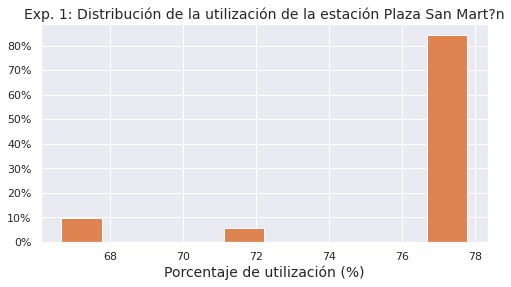

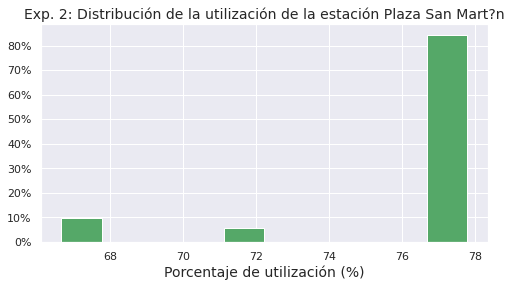

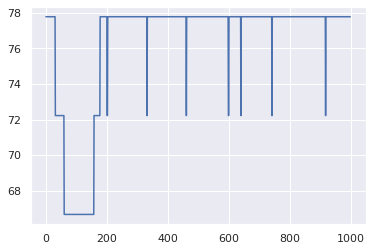

In [93]:
exp_id = 1

highest_utilization = eval(f'summary_occupation_exp_{exp_id}').loc['50%'].max()
highest_utilization_station_id = eval(f'summary_occupation_exp_{exp_id}').loc['50%'].argmax()

fig, ax = plt.subplots(1, 2, figsize=(20, 7))
ax[0].plot(eval(f'occupation_values_exp_{exp_id}')[highest_utilization_station_id])
ax[0].set_title('Porcentaje de uso a lo largo de la')

In [96]:
confidence_intervals

,Cota inferior,Media,Cota superior
totalUsers,[nan],0.0,[nan]
co2Avoided,[nan],0.0,[nan]
totalKm,[nan],0.0,[nan]
totalLostCustomers,[nan],0.0,[nan]
delayedUsers,[nan],0.0,[nan]
totalLostTime,[nan],0.0,[nan]


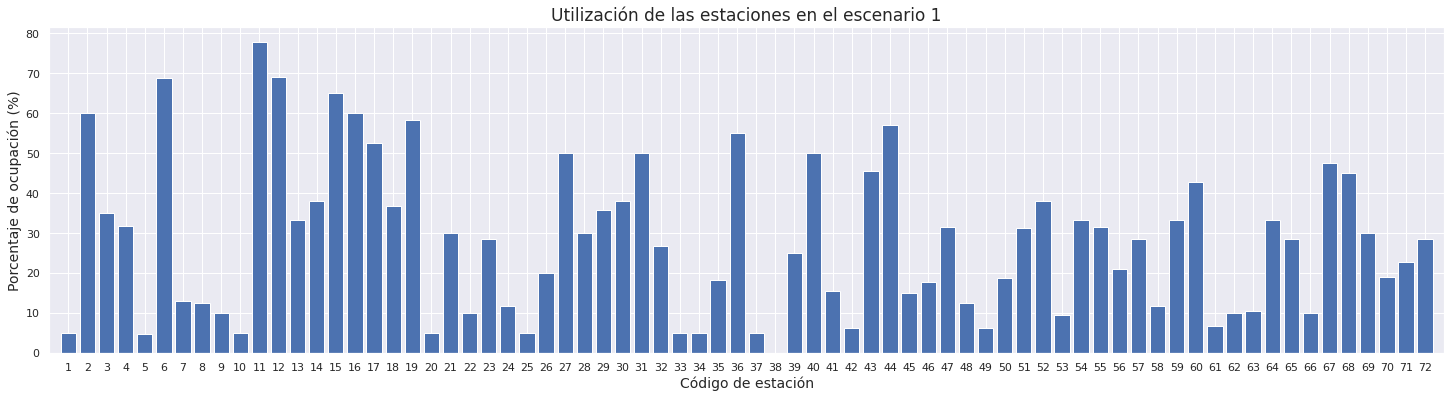

In [91]:
fig, ax = plt.subplots(figsize=(25,6))
ax.bar(x=station_codes, height=summary_occupation_exp_1.loc['50%', :])
ax.set_ylabel('Porcentaje de ocupación (%)', fontdict={'size': 14})
ax.set_xlabel('Código de estación', fontdict={'size': 14})
ax.set_xticks(station_codes)
ax.set_title('Utilización de las estaciones en el escenario 1', fontdict={'size': 17})
ax.set_xlim(0,n_stations+1)
fig.savefig(f'{processed_output_path}/stations-utilization-1.pdf', dpi=100)

In [29]:
for file in [2,3], [4,5]:
    print(file)

[2, 3]
[4, 5]


In [26]:
def mean_confidence_interval(data, confidence=0.90):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [27]:
res1 = np.random.normal(size=50)
res2 = np.random.normal(size=50)
mean_confidence_interval(res1 - res2)

(0.12735471512364896, -0.20198907394917678, 0.45669850419647473)

In [2]:
n_experiments = 2
n_replications = 2
n_executions = n_experiments * n_replications

statistics = (
    'totalUsers',
    'co2Avoided',
    'totalKm',
    'totalLostCustomers',
    'delayedUsers',
    'totalLostTime',
)

results = { f'{statistic}': [] for statistic in statistics }
stations_population_data = []

for exp in range(1, n_experiments + 1):
    for rep in range(1, n_replications + 1):
        file = open(f'../Modelo/MiBiciTuBici/model-output/output-exp{exp}-rep{rep}.json')
        data = json.load(file)
        stations_population_data.append(data['estaciones']) 

        for statistic in statistics:
            results[statistic].append(data[statistic]) 

In [7]:
results.keys()

dict_keys(['totalUsers', 'co2Avoided', 'totalKm', 'totalLostCustomers', 'delayedUsers', 'totalLostTime'])

In [13]:
len(stations_population_data)

4

tengo 4 ejecuciones, cada ejecución tiene datos de 72 estaciones

In [15]:
stations_population_data[1][0] # datos de la segunda ejecución, primera estación
stations_population_data[1][0]['bikesDeposited'] # datos de la segunda ejecución, primera estación

19

In [16]:
stations_population_data[1][0]['percentageOfOccupation'] # datos de la segunda ejecución, primera estación

{'plainDataTable': [[0.0, 5.0],
  [0.016666666666666666, 5.0],
  [0.03333333333333333, 5.0],
  [0.05, 5.0],
  [0.06666666666666667, 5.0],
  [0.08333333333333333, 5.0],
  [0.09999999999999999, 5.0],
  [0.11666666666666665, 5.0],
  [0.13333333333333333, 5.0],
  [0.15, 5.0],
  [0.16666666666666666, 5.0],
  [0.18333333333333332, 5.0],
  [0.19999999999999998, 5.0],
  [0.21666666666666665, 5.0],
  [0.2333333333333333, 5.0],
  [0.24999999999999997, 5.0],
  [0.26666666666666666, 5.0],
  [0.2833333333333333, 5.0],
  [0.3, 5.0],
  [0.31666666666666665, 5.0],
  [0.3333333333333333, 5.0],
  [0.35, 5.0],
  [0.36666666666666664, 5.0],
  [0.3833333333333333, 5.0],
  [0.39999999999999997, 5.0],
  [0.41666666666666663, 5.0],
  [0.4333333333333333, 5.0],
  [0.44999999999999996, 0.0],
  [0.4666666666666666, 0.0],
  [0.4833333333333333, 0.0],
  [0.49999999999999994, 0.0],
  [0.5166666666666666, 0.0],
  [0.5333333333333333, 0.0],
  [0.55, 0.0],
  [0.5666666666666668, 0.0],
  [0.5833333333333335, 0.0],
  [0

In [56]:
print('-> calculating confidence intervals...')
confidence_intervals = { f'{statistic}': None for statistic in statistics }
for statistic, values in results.items():
    mean, lower, upper = mean_confidence_interval(values)
    confidence_intervals[statistic] = (lower, mean, upper)
    
confidence_intervals = pd.DataFrame(confidence_intervals).T
confidence_intervals.columns = ('Cota inferior', 'Media', 'Cota superior')
confidence_intervals = confidence_intervals.round(decimals=2)
confidence_intervals.to_csv('../Modelo/MiBiciTuBici/processed-model-output/intervals.csv')

print('-> generating summary of results...')
pd.DataFrame(results).describe().T.to_csv('../Modelo/MiBiciTuBici/processed-model-output/stats.csv')

-> calculating confidence intervals...
-> generating summary of results...


In [5]:
n_stations = len(stations_population_data[0])
stations_results = [[] for _ in range(n_stations)]

for i in range(n_executions):
    for j in range(n_stations):
        stations_results[j].append(stations_population_data[i][j])

-> generating histograms for station 0
-> generating histograms for station 1
-> generating histograms for station 2
-> generating histograms for station 3
-> generating histograms for station 4
Done.


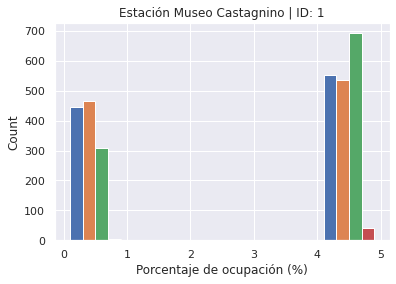

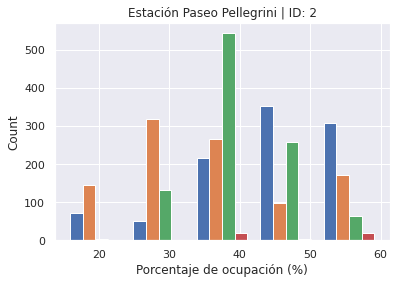

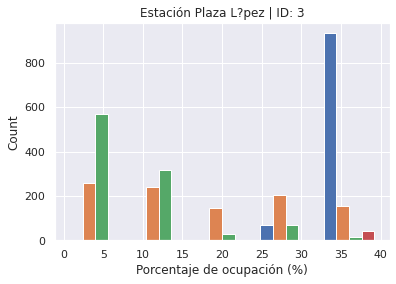

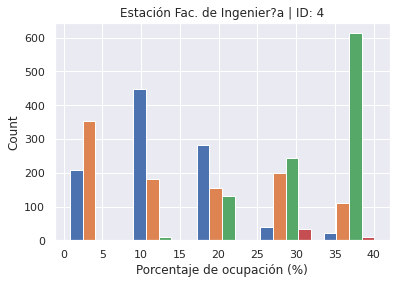

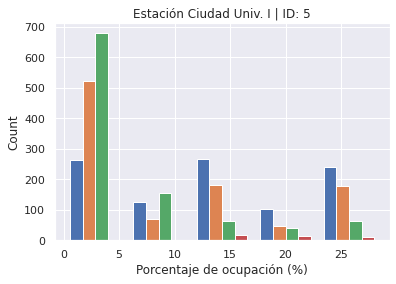

In [55]:
for station_id in range(5):
    print(f'-> generating histograms for station {station_id}')
    station_name = stations_results[station_id][0]['name']
    station_code = stations_results[station_id][0]['stationCode']
    occupied_percentage_along_runs = []
    
    for exec_id in range(n_executions):
         occupied_percentage_along_runs.append(
             np.array([xy[1] for xy in stations_results[station_id][exec_id]['percentageOfOccupation']['plainDataTable'][:-1]])
         )
            
    occupied_percentage_along_runs = np.array(occupied_percentage_along_runs, dtype=object).flatten()
    fig, ax = plt.subplots()
    ax.hist(occupied_percentage_along_runs, bins=5)
    ax.set_title(f"Estación {station_name} | ID: {station_code}")
    ax.set_xlabel('Porcentaje de ocupación (%)')
    ax.set_ylabel('Count')
    fig.savefig(f'../Modelo/MiBiciTuBici/processed-model-output/histogram-code{station_code}.pdf', dpi=100)
    
print('Done.')